# Các điểm cần lưu ý ở Hồi quy đa biến
[BS. Vương Kiến Thanh](https://vuongkienthanh.github.io)

## Bài 1: Hồi quy đa biến giúp phát hiện những mối tương quan giả (spurious relationship)

### Simulation: Giả sử ta có mối quan hệ sau đây:  
A -> B   
A -> C

Biến `C` là outcome, còn `A` và `B` là 2 variable mà ta thu thập.  
Ta sẽ thử hồi quy đơn biến với `C ~ A` và `C ~ B`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel as CGM

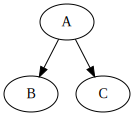

In [2]:
CGM(nodes=['A','B','C'],
    edges=[('A', 'B'), ('A','C')]
).draw()

In [3]:
A = np.random.normal(loc=0, scale=1, size =100)
B = np.random.normal(loc=A, scale=1)
C = np.random.normal(loc=A+1, scale=1)

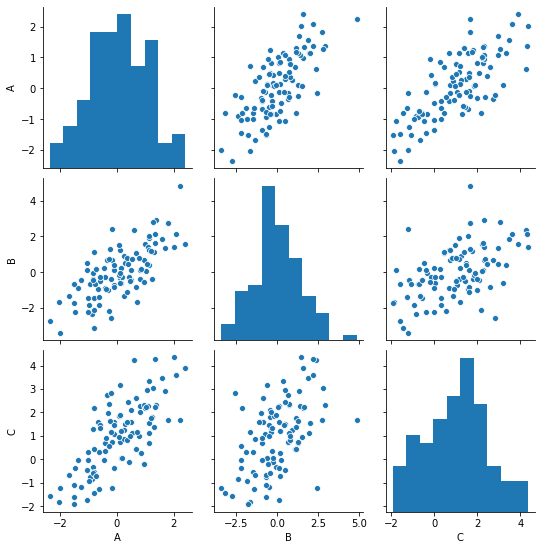

In [4]:
sns.pairplot(pd.DataFrame(np.vstack([A,B,C]).T, columns=['A','B','C']));

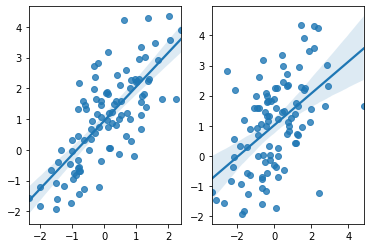

In [5]:
sns.regplot(A, C, ax=plt.subplot(1,2,1))
sns.regplot(B, C, ax=plt.subplot(1,2,2));

#### Nhận xét:
Cả 2 `A` và `B` đều có **tương quan dương** với biến `C` .  

Hãy xem hệ số hồi quy của 2 model này.

In [6]:
from sklearn.linear_model import LinearRegression as OLS

m1 = OLS()
m1.fit(A.reshape(-1,1),C)

m2 = OLS()
m2.fit(B.reshape(-1,1),C)

m1.coef_, m2.coef_

(array([1.10486521]), array([0.52658388]))

Hãy xem chuyện gì xảy ra với hồi quy đa biến `C ~ A + B`

In [7]:
m3 = OLS()
m3.fit(np.vstack([A,B]).T,
        C)
m3.coef_

array([ 1.16439819, -0.05812925])

#### Nhận xét:
Hệ số của A không thay đổi nhiều, trong khi hệ số của B đã bị tụt về zero. Nếu bạn dùng `statsmodels` để fit mô hình thì sẽ thấy p-value của hệ số của B sẽ không có significant. 

## Chuyện gì đã xảy ra?
Mô hình hồi quy đa biến đã cho hệ số hồi quy phù hợp với data mô phỏng ban đầu của ta, tổi thiểu hoá hệ số của biến (ở đây là biến `B`) mà không có ảnh hưởng đến outcome của data.
## Ta gọi tương quan ban đầu giữa `B` và `C` là một [spurious relationship.](https://en.wikipedia.org/wiki/Spurious_relationship)  

Hiện thực luôn tồn tại những mối quan hệ kiểu này, như:
- Nơi nào nhiều bác sĩ thì nơi đó có tỉ lệ tử vong cao.
- Lượng kem bán được nhiều nhất khi có nhiều ca đuối nước ở hồ bơi nhất. Nhưng thực ra là do cơn nóng gây ra.
- Đeo đồng hồ khi làm việc sẽ tăng năng suất lao động.

Cách tốt nhất để tránh những tình huống này là hãy suy nghĩ mối quan hệ nhân quả trước khi thực hiện phân tích thống kê.

## REAL DATA (sách rethinking)

In [8]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv"
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'
data = pd.read_csv(url, sep=';')[[A,M,D]]
data.head()

,MedianAgeMarriage,Marriage,Divorce
0,25.3,20.2,12.7
1,25.2,26.0,12.5
2,25.8,20.3,10.8
3,24.3,26.4,13.5
4,26.8,19.1,8.0


Biến outcome của ta là `Divorce`, 2 biến predictor là `MedianAgeMarriage` và `Marriage`.  
Mỗi dòng tương ứng với một tiểu bang của Waffle.  

Trước tiên thực hiện hồi quy, ta hãy suy nghĩ tới quan hệ nhân quả:  
- `Tuổi lúc kết hôn` tăng làm giảm `tỉ lệ ly dị`
- `Tỉ lệ kết hôn` tăng làm tăng hoặc giảm `tỉ lệ ly dị`.
- `Tuổi lúc kết hôn` tăng thì `tỉ lệ kết hôn` giảm.

Những liệt kê ở trên đều là giả định.

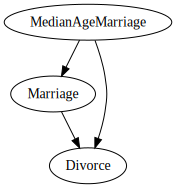

In [9]:
CGM(
    nodes=[A, M, D],
    edges=[(A, M),
           (A, D),
           (M, D)]
).draw()

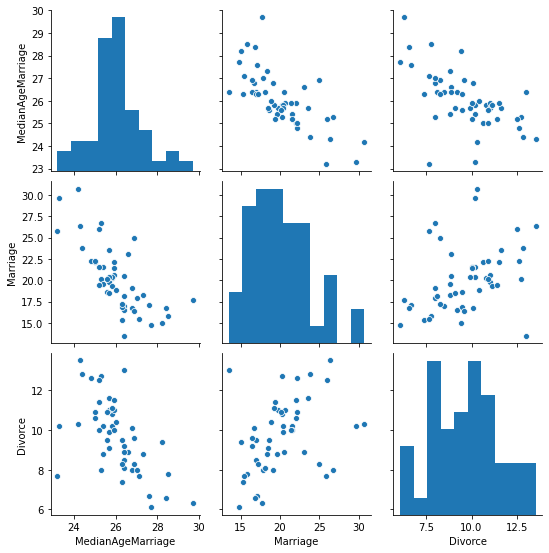

In [10]:
sns.pairplot(data);

Theo pairplot, ta thấy:
- `A D` là corr âm
- `M D` là corr dương
- `A M` là corr âm

Hãy xem hồi quy đơn biến `D ~ A` và `D ~ M`

In [11]:
m4 = OLS()
m4.fit(data[[A]], data[D])


m5 = OLS()
m5.fit(data[[M]], data[D])

m4.coef_, m5.coef_

(array([-0.87442501]), array([0.1791765]))

Vâng, hệ số hồi quy cũng khá gần giống correlation.  
Hãy xem hồi quy đa biến như thế nào.

In [12]:
m6 = OLS()
m6.fit(data[[A,M]], data[D])
m6.coef_

array([-0.99964954, -0.0568648 ])

Hệ số của `A` hầu như không thay đổi, trong khi hệ số của `M` chuyển từ dương sang âm về gần với zero, điều này chứng tỏ `Tỉ lệ kết hôn` không liên quan hoặc liên quan rất ít với `tỉ lệ ly dị`.

## Như vậy, tương quan giữa `M` và `D` là một spurious relationship. Mặc dù chúng tương quan nhau nhưng không hề có quan hệ nhân quả ở đây.

In [13]:
import graphviz as gv
import networkx as nx

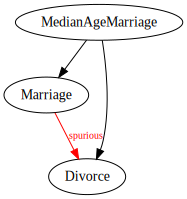

In [14]:
g = CGM(nodes=[A,M,D],
    edges=[(A, D), (A,M)]
)
G = nx.nx_agraph.to_agraph(g.dag)
G.add_edge(M,D, color='red', label='spurious', fontcolor='red', fontsize=10)
gv.Source(G.string(), engine='dot')

### Counterfactual plot
Để visualize mối quan hệ spurious này, ta có thể đặt `A=25` (trung bình của data) và control `M` thành số mình mong muốn.  
Nghĩa là với `Tuổi trung bình kết hôn là 25` và với `Kiểm soát tỉ lệ kết hôn` thì `Tỉ lệ ly dị` như thế nào.

In [15]:
import statsmodels.api as sm

In [16]:
m7 = sm.OLS(endog=data[D], exog=sm.add_constant(data[[A,M]])).fit()
m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Divorce   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     13.42
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           2.46e-05
Time:                        09:30:32   Log-Likelihood:                -89.114
No. Observations:                  50   AIC:                             184.2
Df Residuals:                      47   BIC:                             190.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                36.8766      7.661      4.814      0.000      21.465      52.289
MedianAgeMarriage    -0.9996      0.246     -4.065      0.000      -1.494      -0.505
Marriage             -0.0569      0.081     -0.706      0.484      -0.219       0.105
==============================================================================
Omnibus:                        2.545   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.595
Skew:                          -0.301   Prob(JB):                        0.450
Kurtosis:                       3.635   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
def counterfactual_plot(x, y_data, label):
    plt.plot(x, y_data.predicted_mean)
    plt.fill_between(x,
                     y1=y_data.predicted_mean - 2*y_data.se_mean,
                     y2=y_data.predicted_mean + 2*y_data.se_mean,
                     alpha=0.5)
    plt.fill_between(x,
                     y1=y_data.predicted_mean - 2*y_data.se_obs,
                     y2=y_data.predicted_mean + 2*y_data.se_obs,
                     alpha=0.1, color='k')
    plt.title(label)
    plt.show()

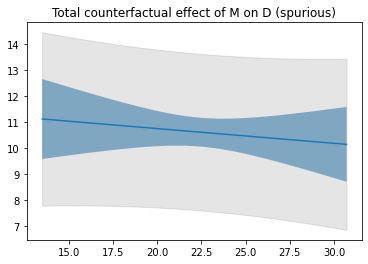

In [18]:
m_sim = np.linspace(data[M].min(), data[M].max(), 20)
a_sim = np.ones(20)*25
consta = np.ones(20)

d_pred = m7.get_prediction(np.vstack([consta,a_sim, m_sim]).T)

counterfactual_plot(m_sim, d_pred, "Total counterfactual effect of M on D (spurious)")

### Nó được gọi là counterfactual plot bởi vì:
Trong thực tế không thể nào giả định một trạng thái cố định và thay đổi biến số cần khảo sát theo mong muốn được. Anh không thể nào ép mọi người phải cưới vào độ tuổi 25 và kiểm soát tỉ lệ kết hôn ở từng tiểu bang trong Waffle được.

Nhưng với Counterfactual plot, ta hiểu rõ hơn những giả định mà ta đã áp đặt lên model của chúng ta và cách nó hoạt động.

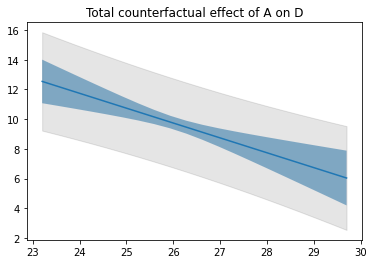

In [19]:
a_sim = np.linspace(data[A].min(), data[A].max(), 20)
m_sim = np.ones(20) * data[M].mean()
consta = np.ones(20)

d_pred = m7.get_prediction(np.vstack([consta,a_sim, m_sim]).T)

counterfactual_plot(a_sim, d_pred, "Total counterfactual effect of A on D")

# Hãy kiểm tra lại những gì ta mới học
Ta sẽ mô phỏng lại toàn bộ phân tích nhưng với quan hệ nhân quả thực sự (không phải spurious)

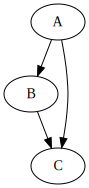

In [20]:
CGM(nodes=['A','B','C'],
    edges=[('A', 'B'), ('A','C'), ('B','C')]
).draw()

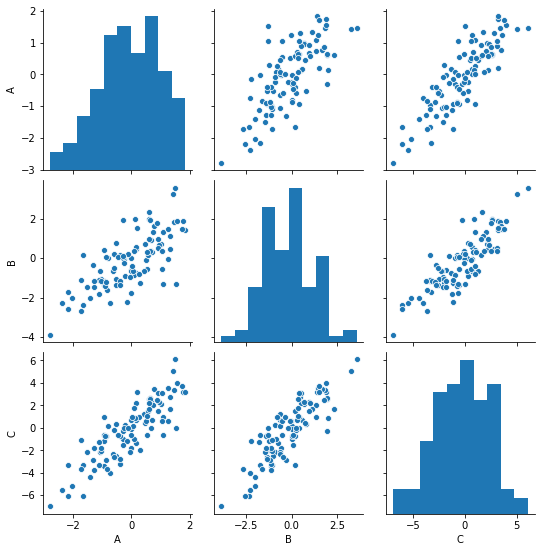

In [21]:
A = np.random.normal(loc=0, scale=1, size =100)
B = np.random.normal(loc=A, scale=1)
C = np.random.normal(loc=A+B, scale=1)

sns.pairplot(pd.DataFrame(np.vstack([A,B,C]).T, columns=['A','B','C']));

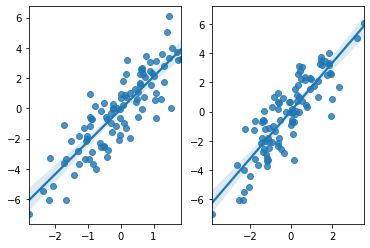

In [22]:
sns.regplot(A, C, ax=plt.subplot(1,2,1))
sns.regplot(B, C, ax=plt.subplot(1,2,2));

In [23]:
m8 = OLS()
m8.fit(A.reshape(-1,1),C)

m9 = OLS()
m9.fit(B.reshape(-1,1),C)

m10 = OLS()
m10.fit(np.vstack([A,B]).T,
        C)

print(m8.coef_, m9.coef_, m10.coef_, sep='\n')

[2.15142537]
[1.62985986]
[1.24551203 0.93974686]


Như vậy, model đã phân biệt rất tốt nhưng mối tương quan spurious.  
Kết quả kiểm tra trên là một hiện tượng mới gọi là `masked relationship`. Tôi sẽ nói ở bài sau.

In [24]:
m11 = sm.OLS(endog=C, exog=sm.add_constant(np.vstack([A,B]).T)).fit()

m11.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0278,0.102,0.274,0.785,-0.174,0.229
x1,1.2455,0.143,8.694,0.000,0.961,1.530
x2,0.9397,0.109,8.653,0.000,0.724,1.155


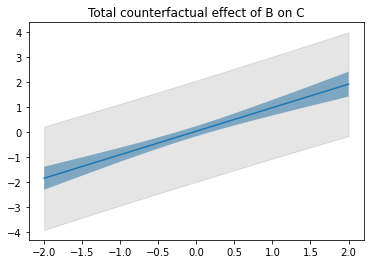

In [25]:
A_sim = np.zeros(20)
B_sim = np.linspace(-2,2,20)
consta = np.ones(20)

C_pred = m11.get_prediction(np.vstack([consta,A_sim, B_sim]).T)

counterfactual_plot(B_sim, C_pred, "Total counterfactual effect of B on C")

# Have a nice day!